In [1]:
from pathlib import Path
import pandas as pd
import numpy as np  # for numerical operations

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data_processed"

# Load segmented fact table
fact_path = DATA_PROCESSED / "order_lines_full_segmented.csv"
order_lines = pd.read_csv(fact_path)

# Optional: shuffle and sample for modeling
model_df = (
    order_lines
    .sample(frac=0.1, random_state=42)  # take 10% random sample
    .reset_index(drop=True)
)

model_df.shape


(3243449, 17)

In [2]:
# 1) PRODUCT-LEVEL FEATURES
product_stats = (
    order_lines
    .groupby("product_id")
    .agg(
        prod_total_orders=("order_id", "nunique"),        # in how many orders does this product appear
        prod_total_units=("line_qty", "sum"),             # total units sold
        prod_mean_add_to_cart=("add_to_cart_order", "mean"),  # usually added early or late in cart?
        prod_reorder_rate=("reordered", "mean")          # % of times this product was reordered
    )
    .reset_index()
)

product_stats.head()


,product_id,prod_total_orders,prod_total_units,prod_mean_add_to_cart,prod_reorder_rate
0,1,1852,1852,5.801836,0.613391
1,2,90,90,9.888889,0.133333
2,3,277,277,6.415162,0.732852
3,4,329,329,9.507599,0.446809
4,5,15,15,6.466667,0.600000


In [3]:
# 2) USER-LEVEL FEATURES
user_stats = (
    order_lines
    .groupby("user_id")
    .agg(
        user_total_orders=("order_id", "nunique"),        # how many orders this user has placed
        user_total_units=("line_qty", "sum"),             # how many items they bought in total
        user_mean_basket_size=("order_id", "size"),       # avg lines per order
        user_reorder_rate=("reordered", "mean"),          # how often they reorder overall
        user_avg_days_between_orders=("days_since_prior_order", "mean")  # purchase frequency
    )
    .reset_index()
)

user_stats.head()


,user_id,user_total_orders,user_total_units,user_mean_basket_size,user_reorder_rate,user_avg_days_between_orders
0,1,10,59,59,0.694915,20.259259
1,2,14,195,195,0.476923,15.967033
2,3,12,88,88,0.625000,11.487179
3,4,5,18,18,0.055556,15.357143
4,5,4,37,37,0.378378,14.500000


In [4]:
# 3) USER-PRODUCT INTERACTION FEATURES
user_product_stats = (
    order_lines
    .groupby(["user_id", "product_id"])
    .agg(
        up_times_bought=("order_id", "count"),   # how many times this user bought this product
        up_last_order_number=("order_number", "max"),  # recency: last order index
        up_first_order_number=("order_number", "min")  # how early they started buying it
    )
    .reset_index()
)

# Derive recency-like feature: how recently was this product bought relative to user's history
user_product_stats["up_order_span"] = (
    user_product_stats["up_last_order_number"] - user_product_stats["up_first_order_number"]
)
user_product_stats.head()


,user_id,product_id,up_times_bought,up_last_order_number,up_first_order_number,up_order_span
0,1,196,10,10,1,9
1,1,10258,9,10,2,8
2,1,10326,1,5,5,0
3,1,12427,10,10,1,9
4,1,13032,3,10,2,8


In [5]:
# Start from sampled modeling dataset
X_df = model_df.copy()

# Merge product-level features
X_df = X_df.merge(product_stats, on="product_id", how="left")

# Merge user-level features
X_df = X_df.merge(user_stats, on="user_id", how="left")

# Merge user-product interaction features
X_df = X_df.merge(user_product_stats, on=["user_id", "product_id"], how="left")

X_df.head()


,order_id,product_id,add_to_cart_order,reordered,line_qty,product_name,aisle_id,department_id,aisle,department,...,prod_reorder_rate,user_total_orders,user_total_units,user_mean_basket_size,user_reorder_rate,user_avg_days_between_orders,up_times_bought,up_last_order_number,up_first_order_number,up_order_span
0,3109255,34099,16,0,1,Crushed Red Chili Pepper,104,13,spices seasonings,pantry,...,0.130496,36,711,711,0.621660,9.443149,1,9,9,0
1,301098,41950,5,0,1,Organic Tomato Cluster,83,4,fresh vegetables,produce,...,0.657360,36,625,625,0.651200,5.100162,2,4,2,2
2,1181866,45066,8,0,1,Honeycrisp Apple,24,4,fresh fruits,produce,...,0.724818,51,533,533,0.814259,7.084615,2,5,2,3
3,1678630,8859,2,1,1,Natural Spring Water,115,7,water seltzer sparkling water,beverages,...,0.758377,29,134,134,0.753731,13.576923,23,29,1,28
4,644090,24781,2,0,1,"PODS Laundry Detergent, Ocean Mist Designed fo...",75,17,laundry,household,...,0.166667,22,82,82,0.597561,15.833333,1,7,7,0


In [6]:
# Target variable
y = X_df["reordered"]   # 0 or 1

# Simple set of numeric features for first model
feature_cols = [
    "add_to_cart_order",
    "prod_total_orders",
    "prod_total_units",
    "prod_mean_add_to_cart",
    "prod_reorder_rate",
    "user_total_orders",
    "user_total_units",
    "user_mean_basket_size",
    "user_reorder_rate",
    "user_avg_days_between_orders",
    "up_times_bought",
    "up_order_span",
]

# Handle missing values: replace NaN with 0 for now (simple baseline)
X = X_df[feature_cols].fillna(0)
X.head()


,add_to_cart_order,prod_total_orders,prod_total_units,prod_mean_add_to_cart,prod_reorder_rate,user_total_orders,user_total_units,user_mean_basket_size,user_reorder_rate,user_avg_days_between_orders,up_times_bought,up_order_span
0,16,705,705,10.307801,0.130496,36,711,711,0.621660,9.443149,1,0
1,5,64289,64289,8.640498,0.657360,36,625,625,0.651200,5.100162,2,2
2,8,79769,79769,7.391129,0.724818,51,533,533,0.814259,7.084615,2,3
3,2,19518,19518,4.925658,0.758377,29,134,134,0.753731,13.576923,23,28
4,2,60,60,8.566667,0.166667,22,82,82,0.597561,15.833333,1,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keep same class balance in train and test
)

# Create logistic regression model
log_reg = LogisticRegression(
    max_iter=1000,        # allow more iterations to converge
    n_jobs=-1             # use all CPU cores if possible
)

# Fit the model
log_reg.fit(X_train, y_train)

# Predict probabilities on test set
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluate using ROC-AUC (good for probability classifiers)
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", auc)


/Users/binhvo/jupyter_category_analytics_parent/jupyter_category_analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC: 0.8935224124029758


In [8]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)

feature_importance


,feature,coef
10,up_times_bought,2.781367e-01
11,up_order_span,3.859078e-02
8,user_reorder_rate,1.989388e-02
4,prod_reorder_rate,1.122012e-02
6,user_total_units,3.821945e-04
7,user_mean_basket_size,3.821945e-04
1,prod_total_orders,1.433227e-07
2,prod_total_units,1.433227e-07
9,user_avg_days_between_orders,-1.612189e-02
5,user_total_orders,-1.890695e-02


In [9]:
# Rename columns to more semantic, business-friendly names

rename_map = {
    "add_to_cart_order": "pos_in_cart",                      # position in basket
    "prod_total_orders": "product_orders_count",             # in how many orders this product appears
    "prod_total_units": "product_units_sold",                # total units sold
    "prod_mean_add_to_cart": "product_avg_cart_position",    # average position in cart
    "prod_reorder_rate": "product_reorder_rate",             # historical reorder rate of product
    "user_total_orders": "customer_orders_count",            # how many orders this customer has placed
    "user_total_units": "customer_units_bought",             # total units bought by customer
    "user_mean_basket_size": "customer_avg_basket_size",     # avg lines per order for this customer
    "user_reorder_rate": "customer_reorder_rate",            # overall reorder rate of this customer
    "user_avg_days_between_orders": "customer_avg_days_between_orders",  # purchase frequency
    "up_times_bought": "cust_prod_times_bought",             # times this customer bought this product
    "up_order_span": "cust_prod_order_span",                 # span between first and last purchase
}

X_df = X_df.rename(columns=rename_map)

# New feature list with renamed columns
feature_cols_semantic = list(rename_map.values())

# Build X, y again using new names
y = X_df["reordered"]
X = X_df[feature_cols_semantic].fillna(0)

X.head()


,pos_in_cart,product_orders_count,product_units_sold,product_avg_cart_position,product_reorder_rate,customer_orders_count,customer_units_bought,customer_avg_basket_size,customer_reorder_rate,customer_avg_days_between_orders,cust_prod_times_bought,cust_prod_order_span
0,16,705,705,10.307801,0.130496,36,711,711,0.621660,9.443149,1,0
1,5,64289,64289,8.640498,0.657360,36,625,625,0.651200,5.100162,2,2
2,8,79769,79769,7.391129,0.724818,51,533,533,0.814259,7.084615,2,3
3,2,19518,19518,4.925658,0.758377,29,134,134,0.753731,13.576923,23,28
4,2,60,60,8.566667,0.166667,22,82,82,0.597561,15.833333,1,0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_proba)
print("Logistic Regression ROC-AUC:", auc_log)

# Semantic feature importance
feature_importance_log = (
    pd.DataFrame({
        "feature": feature_cols_semantic,
        "coef": log_reg.coef_[0]
    })
    .sort_values("coef", ascending=False)
)
feature_importance_log


/Users/binhvo/jupyter_category_analytics_parent/jupyter_category_analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression ROC-AUC: 0.8935224124029758


,feature,coef
10,cust_prod_times_bought,2.781367e-01
11,cust_prod_order_span,3.859078e-02
8,customer_reorder_rate,1.989388e-02
4,product_reorder_rate,1.122012e-02
6,customer_units_bought,3.821945e-04
7,customer_avg_basket_size,3.821945e-04
1,product_orders_count,1.433227e-07
2,product_units_sold,1.433227e-07
9,customer_avg_days_between_orders,-1.612189e-02
5,customer_orders_count,-1.890695e-02


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# Use same X_train, X_test, y_train, y_test as above
gb_clf = GradientBoostingClassifier(
    n_estimators=200,      # number of trees
    learning_rate=0.05,   # smaller learning rate, more stable
    max_depth=3,          # shallow trees to avoid overfitting
    random_state=42
)

gb_clf.fit(X_train, y_train)

y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("Gradient Boosting ROC-AUC:", auc_gb)

# Tree-based feature importance
gb_importance = (
    pd.DataFrame({
        "feature": feature_cols_semantic,
        "importance": gb_clf.feature_importances_
    })
    .sort_values("importance", ascending=False)
)
gb_importance


Gradient Boosting ROC-AUC: 0.9064859718651948


,feature,importance
10,cust_prod_times_bought,5.241690e-01
11,cust_prod_order_span,4.711724e-01
0,pos_in_cart,3.584884e-03
6,customer_units_bought,4.024051e-04
7,customer_avg_basket_size,3.746777e-04
5,customer_orders_count,2.110903e-04
9,customer_avg_days_between_orders,3.831901e-05
8,customer_reorder_rate,3.046057e-05
3,product_avg_cart_position,1.475064e-05
4,product_reorder_rate,1.742332e-06


In [12]:
# Optional: XGBoost if installed (pip install xgboost)
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("XGBoost ROC-AUC:", auc_xgb)


XGBoost ROC-AUC: 0.9071082373156155


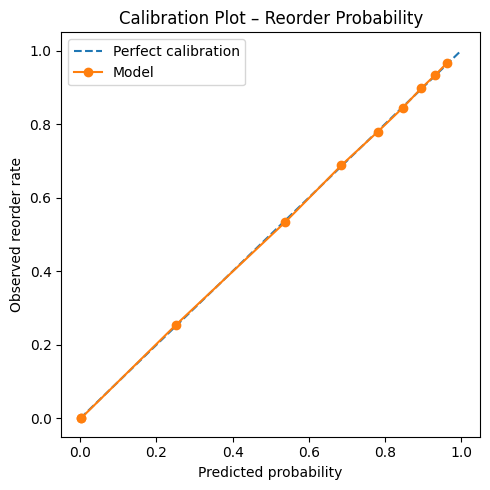

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Choose which model's probabilities to inspect
probs = y_pred_proba_gb      # or y_pred_proba_xgb / y_pred_proba

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, probs, n_bins=10, strategy="quantile"
)

plt.figure(figsize=(5,5))
# Perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")

# Model curve
plt.plot(mean_predicted_value, fraction_of_positives, marker="o", label="Model")

plt.xlabel("Predicted probability")
plt.ylabel("Observed reorder rate")
plt.title("Calibration Plot – Reorder Probability")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
segments_to_model = ["Food", "Snacking", "Pet"]

segment_models = {}
segment_metrics = {}

for seg in segments_to_model:
    print(f"\n=== Segment: {seg} ===")
    
    seg_df = X_df[X_df["segment"] == seg].copy()
    
    y_seg = seg_df["reordered"]
    X_seg = seg_df[feature_cols_semantic].fillna(0)
    
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_seg, y_seg,
        test_size=0.2,
        random_state=42,
        stratify=y_seg
    )
    
    gb_seg = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    gb_seg.fit(X_train_s, y_train_s)
    
    y_pred_proba_seg = gb_seg.predict_proba(X_test_s)[:, 1]
    auc_seg = roc_auc_score(y_test_s, y_pred_proba_seg)
    
    print("ROC-AUC:", auc_seg)
    
    segment_models[seg] = gb_seg
    segment_metrics[seg] = auc_seg



=== Segment: Food ===


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Build / reload user_stats from full fact table
user_stats = (
    order_lines
    .groupby("user_id")
    .agg(
        orders_count=("order_id", "nunique"),
        total_units=("line_qty", "sum"),
        avg_basket_size=("order_id", "size"),
        reorder_rate=("reordered", "mean"),
        avg_days_between_orders=("days_since_prior_order", "mean")
    )
)

# Features for clustering
cluster_features = ["orders_count", "total_units", "avg_basket_size", "reorder_rate", "avg_days_between_orders"]

X_users = user_stats[cluster_features].fillna(0)

# Scale features for KMeans
scaler = StandardScaler()
X_users_scaled = scaler.fit_transform(X_users)

# Choose number of clusters (e.g. 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
user_stats["cluster"] = kmeans.fit_predict(X_users_scaled)

user_stats.groupby("cluster")[cluster_features].mean()


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Build basket matrix: order_id x product_id (1 if present)
# To keep it light, sample a subset of orders
sample_orders = (
    order_lines
    .sample(frac=0.02, random_state=42)[["order_id", "product_id"]]
)

basket = (
    sample_orders
    .assign(value=1)
    .pivot_table(index="order_id", columns="product_id", values="value", fill_value=0)
)

# Frequent itemsets (minimum support can be tuned)
frequent_itemsets = apriori(
    basket,
    min_support=0.01,   # products appearing in at least 1% of sampled baskets
    use_colnames=True
)

# Generate association rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.1
)

# Sort by lift (strength of association)
rules_sorted = rules.sort_values("lift", ascending=False)

rules_sorted.head(10)
